In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/usr/local/python/openpose')
from openpose import *
from collections import deque
from tqdm import tqdm_notebook as tqdm
import pandas as pd

# OpenPose のパラメータ設定

In [2]:
# Parameters for OpenPose.
# Take a look at C++ OpenPose example for meaning of components.
# Ensure all below are filled
params = dict()
params["logging_level"] = 3
params["output_resolution"] = "-1x-1"
params["net_resolution"] = "-1x368"
params["model_pose"] = "BODY_25"
params["alpha_pose"] = 0.6
params["scale_gap"] = 0.3
params["scale_number"] = 1
params["render_threshold"] = 0.05
# If GPU version is built, and multiple GPUs are available, set the ID here
params["num_gpu_start"] = 0
params["disable_blending"] = False
# Ensure you point to the correct path where models are located
#params["default_model_folder"] = dir_path + "/../../../models/"
params["default_model_folder"] = "/home/takataka/180929/openpose/models/"

In [3]:
# Construct OpenPose object allocates GPU memory
openpose = OpenPose(params)

In [4]:
# BODY_25 Output Format
keypointsMapping = {
    0: 'Nose',
    1: 'Neck',
    2: 'RShoulder',
    3: 'RElbow',
    4: 'RWrist',
    5: 'LShoulder',
    6: 'LElbow',
    7: 'LWrist',
    8: 'MidHip',
    9: 'RHip',
    10: 'RKnee',
    11: 'RAnkle',
    12: 'LHip',
    13: 'LKnee',
    14: 'LAnkle',
    15: 'REye',
    16: 'LEye',
    17: 'REar',
    18: 'LEar',
    19: "LBigToe",
    20: "LSmallToe",
    21: "LHeel",
    22: "RBigToe",
    23: "RSmallToe",
    24: "RHeel",
    25: "Background"
}

# パス宣言

In [7]:
root_dir = pathlib.Path("../data/fashion550k").resolve()
img_dir_path = root_dir / "photos"
keypoints_dir_path = root_dir / "annotation/keypoints"
img_100_dir_path = img_dir_path / "100"
img_path_list = list(img_dir_path.glob("*/*.jpg"))

# 画像読み込み

In [6]:
img_list = list(img_100_dir_path.glob("*.jpg"))
len(img_list)

4083

In [7]:
# 画像読み込み
img = cv2.cvtColor(cv2.imread(str(img_list[0])), cv2.COLOR_BGR2RGB)
# Output keypoints and the image with the human skeleton blended on it
keypoints, output_image = openpose.forward(img, True)

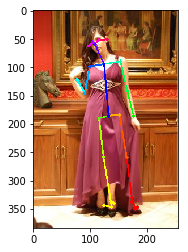

In [8]:
plt.imshow(output_image)

In [42]:
# keypoint を確認
print("keypoint num:", keypoints.shape[1])
keypoints[:,:,2]

keypoint num: 25


array([[0.79730093, 0.76007986, 0.63401955, 0.28121355, 0.09003982,
        0.74003506, 0.7303606 , 0.7946027 , 0.46668482, 0.46899116,
        0.3620848 , 0.3254872 , 0.4312208 , 0.44504306, 0.38483033,
        0.8171457 , 0.8847102 , 0.08611488, 0.7835949 , 0.26354358,
        0.33035085, 0.23138508, 0.18826878, 0.19568193, 0.26014456]],
      dtype=float32)

In [43]:
keypoints[0, -1]

array([1.4238889e+02, 3.3974741e+02, 2.6014456e-01], dtype=float32)

# マップ上に可視化

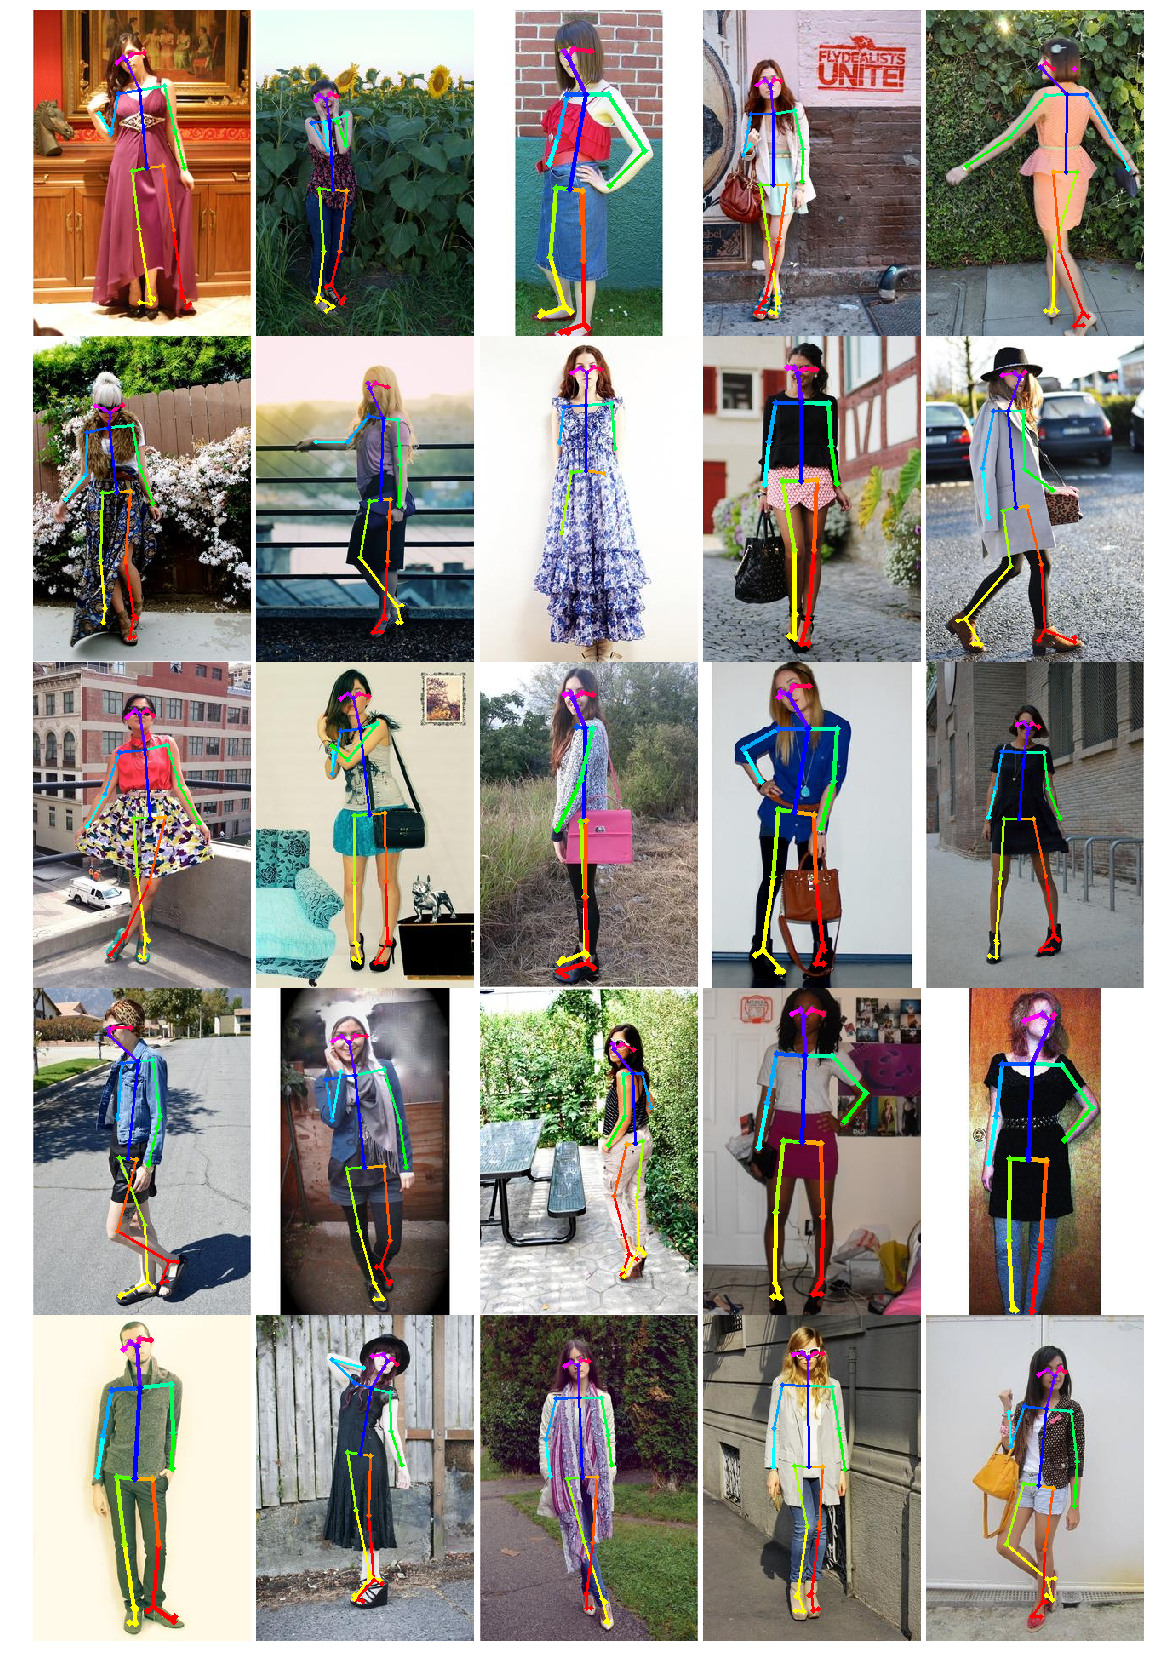

In [27]:
fig, axes = plt.subplots(5, 5, figsize=(20, 30))
for path, ax in zip(img_list, axes.flatten()):
    img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
    keypoints, output_image = openpose.forward(img, True)
    ax.imshow(output_image)
    ax.set_axis_off()
plt.subplots_adjust(hspace=0, wspace=0)
fig.savefig("example_openpose.png", pad_inches=0, bbox_inches="tight")

In [44]:
# 膝から下を推定できていない，７番目のデータのキーポイントリストがどうなっているかをみてみる
img = cv2.cvtColor(cv2.imread(str(img_list[7])), cv2.COLOR_BGR2RGB)
keypoints, output_image = openpose.forward(img, True)
keypoints # 0になっている．

array([[[1.25306946e+02, 4.42195129e+01, 7.03550041e-01],
        [1.24223495e+02, 8.16089554e+01, 5.78813672e-01],
        [9.75604324e+01, 8.37230453e+01, 5.31454921e-01],
        [9.33150024e+01, 1.26396049e+02, 1.64917022e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.54110199e+02, 8.04964142e+01, 3.86432946e-01],
        [1.58422729e+02, 1.32796951e+02, 1.15135573e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.24288559e+02, 1.59468658e+02, 1.81215331e-01],
        [1.07172775e+02, 1.60532791e+02, 1.72541142e-01],
        [9.54477463e+01, 2.32010056e+02, 7.68078938e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.44512421e+02, 1.61592560e+02, 1.63493142e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.16826843e+02, 3.78007622e+01, 7.33174205e-01],
        [1.32748291e+02, 3.67931252e+01, 7.30103731e-01],
        [1.072

# OpenPose を全データに適用し，そのkeypoint を保存する．

In [13]:
path = img_path_list[0]
path

PosixPath('/home/yohei/Documents/tlab/data/fashion550k/photos/273/2734593569-2734593569_400.jpg')

In [15]:
path.stem # 拡張子なしのファイル名

'2734593569-2734593569_400'

In [31]:
save_file_name

'2734593569-2734593569_400.npy'

In [34]:
extention = ".npy"
save_file_name = path.stem + extention  # 保存するファイル名
parent_dir = path.parent.name # 直下のディレクトリ名
if not (keypoints_dir_path / parent_dir).exists():
    (keypoints_dir_path / parent_dir).mkdir()
    print("make {} dir".format((keypoints_dir_path / parent_dir).name))
img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
keypoints, output_image = openpose.forward(img, True)
np.save(str(keypoints_dir_path / parent_dir / save_file_name), keypoints)

In [38]:
np.all(np.load(str(keypoints_dir_path / parent_dir / save_file_name)) == keypoints)

True

In [44]:
# 全データで実行．
extention = ".npy"
path4img = deque(maxlen=len(img_path_list) + 100)
path4keypoints = deque(maxlen=len(img_path_list) + 100)

for path in tqdm(img_path_list):
    save_file_name = path.stem + extention  # 保存するファイル名
    parent_dir = path.parent.name  # 直下のディレクトリ名
    if not (keypoints_dir_path / parent_dir).exists(): # ディレクトリがなければ作成
        (keypoints_dir_path / parent_dir).mkdir()
        print("make {} dir".format((keypoints_dir_path / parent_dir).name))
    
    # 画像を読み込み，OpenPose に処理させ，keypoint を保存．
    img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
    keypoints, output_image = openpose.forward(img, True)
    save_file_name = keypoints_dir_path / parent_dir / (path.stem + extention)
    np.save(str(save_file_name), keypoints)
    
    # あっているのか確認
    hoge = np.load(str(save_file_name))
    assert np.all(keypoints == hoge), "not matching"
    
    # 保存パスをappend
    path4img.append(path)
    path4keypoints.append(save_file_name)

make 273 dir
make 608 dir
make 672 dir
make 766 dir
make 750 dir
make 676 dir
make 206 dir
make 666 dir
make 352 dir
make 314 dir
make 937 dir
make 899 dir
make 938 dir
make 436 dir
make 607 dir
make 230 dir
make 263 dir
make 945 dir
make 404 dir
make 966 dir
make 276 dir
make 871 dir
make 465 dir
make 566 dir
make 174 dir
make 383 dir
make 484 dir
make 433 dir
make 597 dir
make 773 dir
make 373 dir
make 671 dir
make 829 dir
make 184 dir
make 361 dir
make 194 dir
make 244 dir
make 731 dir
make 780 dir
make 245 dir
make 904 dir
make 450 dir
make 977 dir
make 693 dir
make 718 dir
make 426 dir
make 522 dir
make 371 dir
make 839 dir
make 661 dir
make 916 dir
make 549 dir
make 472 dir
make 686 dir
make 781 dir
make 351 dir
make 798 dir
make 470 dir
make 266 dir
make 606 dir
make 858 dir
make 513 dir
make 611 dir
make 844 dir
make 238 dir
make 107 dir
make 106 dir
make 455 dir
make 259 dir
make 648 dir
make 307 dir
make 269 dir
make 396 dir
make 735 dir
make 159 dir
make 322 dir
make 740 dir

make 853 dir
make 264 dir
make 424 dir
make 431 dir
make 497 dir
make 807 dir
make 428 dir
make 995 dir
make 552 dir
make 575 dir
make 493 dir
make 818 dir
make 457 dir
make 485 dir
make 367 dir
make 634 dir
make 364 dir
make 877 dir
make 256 dir
make 843 dir
make 595 dir
make 658 dir
make 408 dir
make 943 dir
make 196 dir
make 486 dir
make 214 dir
make 438 dir
make 716 dir
make 584 dir
make 646 dir
make 783 dir
make 308 dir
make 799 dir
make 863 dir
make 953 dir
make 180 dir
make 150 dir
make 797 dir
make 906 dir
make 564 dir
make 622 dir
make 122 dir
make 536 dir
make 164 dir
make 605 dir
make 293 dir
make 630 dir
make 790 dir
make 688 dir
make 498 dir
make 706 dir
make 363 dir
make 305 dir
make 860 dir
make 887 dir
make 309 dir
make 880 dir
make 776 dir
make 593 dir
make 609 dir
make 123 dir
make 187 dir
make 779 dir
make 572 dir
make 474 dir
make 559 dir
make 888 dir
make 861 dir
make 826 dir
make 882 dir
make 802 dir
make 690 dir
make 695 dir
make 804 dir
make 163 dir
make 971 dir

In [49]:
func = lambda path: path.stem

In [54]:
list(map(func, path4img)) == list(map(func, path4keypoints))

True

In [59]:
# データフレームを作成し，保存
df1 = pd.DataFrame(list(path4img), columns=["img_path"])
df2 = pd.DataFrame(list(path4keypoints), columns=["keypoint_path"])
df = pd.concat((df1, df2), axis=1)
df.head()

img_path  \
0  /home/yohei/Documents/tlab/data/fashion550k/ph...   
1  /home/yohei/Documents/tlab/data/fashion550k/ph...   
2  /home/yohei/Documents/tlab/data/fashion550k/ph...   
3  /home/yohei/Documents/tlab/data/fashion550k/ph...   
4  /home/yohei/Documents/tlab/data/fashion550k/ph...   

                                       keypoint_path  
0  /home/yohei/Documents/tlab/data/fashion550k/an...  
1  /home/yohei/Documents/tlab/data/fashion550k/an...  
2  /home/yohei/Documents/tlab/data/fashion550k/an...  
3  /home/yohei/Documents/tlab/data/fashion550k/an...  
4  /home/yohei/Documents/tlab/data/fashion550k/an...

In [62]:
df.to_csv(root_dir / "dataframe.csv", index=False)

In [63]:
%%time
pd.read_csv(root_dir / "dataframe.csv").head()

CPU times: user 1.24 s, sys: 40 ms, total: 1.28 s
Wall time: 1.28 s


img_path  \
0  /home/yohei/Documents/tlab/data/fashion550k/ph...   
1  /home/yohei/Documents/tlab/data/fashion550k/ph...   
2  /home/yohei/Documents/tlab/data/fashion550k/ph...   
3  /home/yohei/Documents/tlab/data/fashion550k/ph...   
4  /home/yohei/Documents/tlab/data/fashion550k/ph...   

                                       keypoint_path  
0  /home/yohei/Documents/tlab/data/fashion550k/an...  
1  /home/yohei/Documents/tlab/data/fashion550k/an...  
2  /home/yohei/Documents/tlab/data/fashion550k/an...  
3  /home/yohei/Documents/tlab/data/fashion550k/an...  
4  /home/yohei/Documents/tlab/data/fashion550k/an...

# OpenPose で推定された人数が１以外のデータを除外

In [12]:
%%time
select_path = deque(maxlen=len(img_path_list))
exclude_path = deque(maxlen=len(img_path_list))

for path in tqdm(img_path_list):
    img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
    # Output keypoints and the image with the human skeleton blended on it
    keypoints, output_image = openpose.forward(img, True)
    if keypoints.shape[0] == 1:
        select_path.append(path)
    else:
        exclude_path.append(path)


CPU times: user 3h 24min 58s, sys: 34min 15s, total: 3h 59min 13s
Wall time: 3h 21min 51s


In [25]:
len(select_path), len(exclude_path)  # 一人じゃなかったデータ数は13791

(391798, 13791)

In [23]:
# frame にして保存
select_path_frame = pd.DataFrame(list(select_path))
exclude_path_frame = pd.DataFrame(list(exclude_path))
select_path_frame.to_pickle("seletion-1_frame.pkl")
exclude_path_frame.to_pickle("deplication-1_frame.pkl")

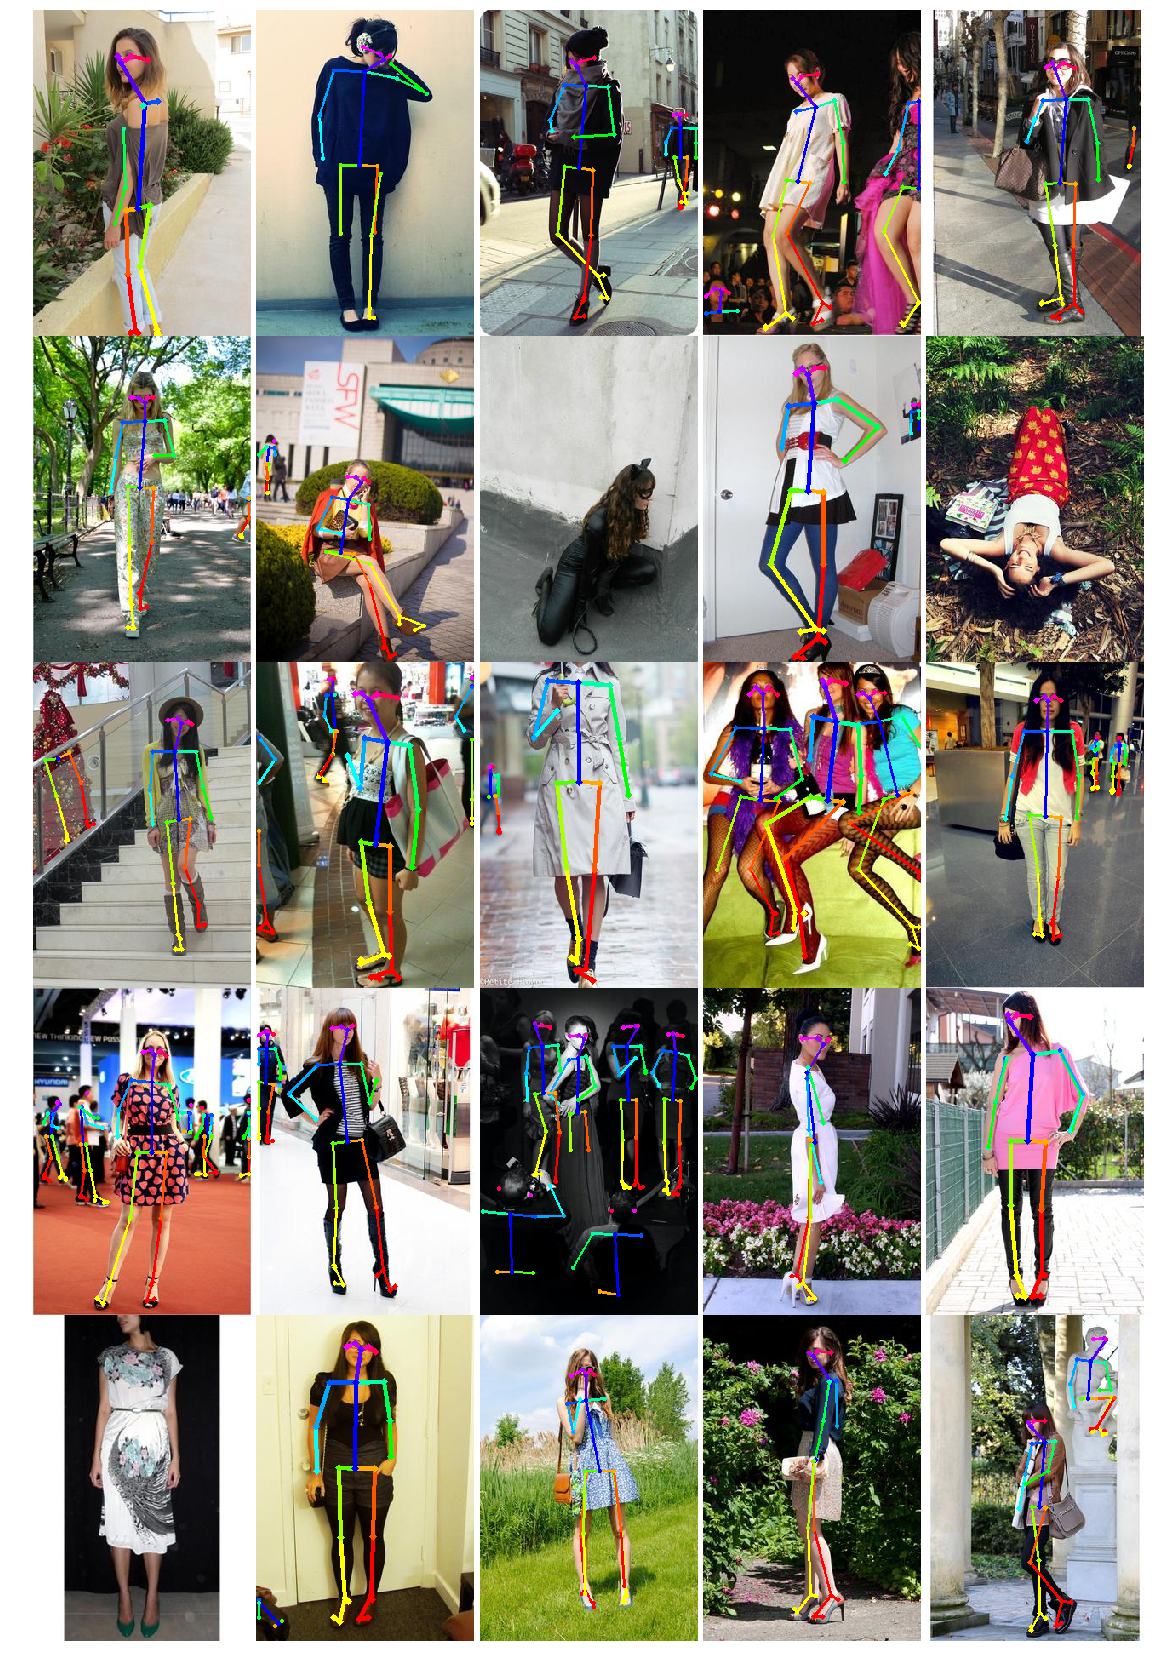

In [28]:
# exclude_parh は本当に推定結果が一人出ないのかを確認
hoge = list(exclude_path)
fig, axes = plt.subplots(5, 5, figsize=(20, 30))
list_ = []
for path, ax in zip(hoge, axes.flatten()):
    img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
    keypoints, output_image = openpose.forward(img, True)
    list_.append(keypoints.shape[0])
    ax.imshow(output_image)
    ax.set_axis_off()
plt.subplots_adjust(hspace=0, wspace=0)
fig.savefig("example_duplicate-1.png", pad_inches=0, bbox_inches="tight")

# 足まで写っているかどうかを推定
足に注目し，足より上の部分は推定されなくても除外しないことにする．  
以下の２つの選択でまずはデータを選択し，データ数とそのデータの平均画像をとる．

写っているかどうかの判断基準は確信度が0以上かどうか．つまり，閾値は0


1. 足が太ももまで（keypoint でいうと10, 13まで）写っているかどうか

1. 足首まで（keypoint でいうと11, 14まで）写っているかどうか

## RKnee, LKnee まで

## 注目するkeypoint の宣言

In [11]:
attention = list(range(11)) + [12,13,15,16,17,18]
attention

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 18]

In [7]:
for i in attention:
    print(keypointsMapping[i])

Nose
Neck
RShoulder
RElbow
RWrist
LShoulder
LElbow
LWrist
MidHip
RHip
RKnee
LHip
LKnee
REye
LEye
REar
LEar


In [8]:
# 画像データへのパス
img_list = list(img_dir_path.glob("*/*.jpg"))
len(img_list)

405589

## １つの画像で試す

In [35]:
# １つ目で試す．
# 画像読み込み
img = cv2.cvtColor(cv2.imread(str(img_list[0])), cv2.COLOR_BGR2RGB)
# Output keypoints and the image with the human skeleton blended on it
keypoints, output_image = openpose.forward(img, True)
degree = keypoints[:, attention, :]
np.prod(degree[:, :, 2] > 0, axis=1)  # 全て検出できていれば1 となる

array([1])

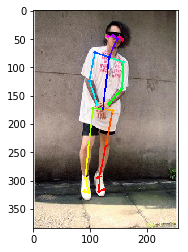

In [30]:
# あっているのか可視化
plt.imshow(output_image)

## 全画像で試す

In [5]:
class Fashion550k():
    def __init__(self, path_list, batch_size):
        self.path_list = path_list
        self.batch_size = batch_size
        self.index = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= len(self.path_list):
            raise StopIteration
        paths = [
            path
            for path in self.path_list[self.index:self.index + self.batch_size]
        ]
        images = cv2.cvtColor(cv2.imread(str(paths[0])),
                              cv2.COLOR_BGR2RGB)[np.newaxis,:]

        for path in paths[1:]:
            image = cv2.cvtColor(cv2.imread(str(path)),
                                 cv2.COLOR_BGR2RGB)[np.newaxis,:]
            images = np.concatenate((images, image),axis=0)
        self.index += self.batch_size
        return paths, images

In [9]:
img_path_list = list(img_dir_path.glob("*/*.jpg")) # パス読み込み

In [15]:
from collections import deque

In [26]:
a = deque(maxlen=len(img_path_list))
for i in range(9):
    a.append(i)

In [ ]:
keypoints, output_images = openpose.forward(images, True)

In [ ]:
# バッチ処理を行う．
fashion550k = Fashion550k(path_list=img_path_list, batch_size=10)
# 画像読み込み
img = cv2.cvtColor(cv2.imread(str(img_list[0])), cv2.COLOR_BGR2RGB)
# Output keypoints and the image with the human skeleton blended on it
keypoints, output_image = openpose.forward(img, True)
degree = keypoints[:, attention, :]
np.prod(degree[:, :, 2] > 0, axis=1)  # 全て検出できていれば1 となる